In [17]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm


#####
## Helper function used to format the x-axis to prevent over-crowding
def format_xticks(axes):
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator(5)) 
        ax.xaxis.set_minor_locator(mdates.YearLocator(1)) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

#####
# Helper function that is used to plot the alogrithmic trading process,
#
# The first plot has 4 different lines/scatter points
# first two are simple plots of the short and long term moving averages
# The last two maps out buy and sell signals and adds '^' or 'v' markers to make it look better
# 
# The second subplot simply traces the profit

def plot_trading_results(data, title):

    fig, axes = plt.subplots(2, 1, figsize=(15, 25), sharex=True)
    fig.suptitle(title, fontsize=16)

    axes[0].plot(data.index, data['short_window'], label="Short-Term MA", color='blue')
    axes[0].plot(data.index, data['long_window'], label="Long-Term MA", color='orange')
    axes[0].scatter(data[data['Action'] == 'Buy'].index, data[data['Action'] == 'Buy']['short_window'], 
                    label="Buy Signal", color='green', marker='^', s=100)
    axes[0].scatter(data[data['Action'] == 'Sell'].index, data[data['Action'] == 'Sell']['short_window'], 
                    label="Sell Signal", color='red', marker='v', s=100)
    axes[0].set_title("Short-Term and Long-Term Moving Averages with Buy/Sell Signals")
    axes[0].set_ylabel("Price (USD)")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(data.index, data['Cumulative_Profit'], label="Cumulative Profit", color='purple')
    axes[1].set_title("Cumulative Profit Over Time")
    axes[1].set_ylabel(f"Profit (USD)")
    axes[1].set_xlabel("Date")
    axes[1].legend()
    axes[1].grid(True)

    format_xticks(axes)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



def create_Business_Cycles(stock_data, ipo_date, BC_1_End, BC_2_End, BC_3_End, yesterday_date):

    # Create the labels based on the provided dates
    stock_data['Business_Cycle'] = 'Stable'  # needs to defual to a certain time period
    stock_data.loc[ipo_date:BC_1_End, 'Business_Cycle'] = 'Startup'
    stock_data.loc[BC_1_End:BC_2_End, 'Business_Cycle'] = 'Growth'
    stock_data.loc[BC_2_End:BC_3_End, 'Business_Cycle'] = 'Maturity'
    stock_data.loc[BC_3_End:yesterday_date, 'Business_Cycle'] = 'Stable'

    return stock_data

In [18]:
#####
# Intialize the different buisness cycles as dates
# reads in the csv, and renames columns
# passes the information through the create Business Cycles function
###

ipo_date = "1962-01-02"
BC_1_End = "1993-03-31"
BC_2_End = "1999-01-01"
BC_3_End = "2010-09-30"
yesterday_date = "2024-12-06"

stock_data = pd.read_csv("IBM_Stock_Data.csv").set_index("Date")
stock_data = stock_data.rename(columns={"IBM":"Close"})


stock_data = create_Business_Cycles(stock_data, ipo_date, BC_1_End, BC_2_End, BC_3_End, yesterday_date)

stock_data

,Close,Business_Cycle
Date,,
1962-01-02,7.291268,Startup
1962-01-03,7.355003,Startup
1962-01-04,7.281708,Startup
1962-01-05,7.138305,Startup
1962-01-08,7.004461,Startup
...,...,...
2024-12-02,227.389999,Stable
2024-12-03,229.000000,Stable
2024-12-04,233.490005,Stable


In [19]:
#####
# moving average function, simply calls on a string then run's either a simple or exponetially weighted moving average
##

def create_MA(stock_data, short_window, long_window, method):

    if method == "SMA":
        stock_data["short_window"] = stock_data["Close"].rolling(short_window).mean()
        stock_data["long_window"] = stock_data["Close"].rolling(long_window).mean()
    if method == "EMA":
        stock_data["short_window"] = stock_data["Close"].ewm(short_window).mean()
        stock_data["long_window"] = stock_data["Close"].ewm(long_window).mean()

    return stock_data.dropna()

#### 
# This function intializes the variables as new columns 
# Then shifts the columns down to obtain two new columns used to detect the status of the short and long windows before the crossing
# A buy signal happens if the short_window is greater than the long window and the pervoius short window was less than the long window and vice versa for sell signials

def detect_crosses(stock_data):

    stock_data = stock_data.copy()

    stock_data['signal'] = 0
    stock_data['Action'] = ""  
    stock_data['Shares_Owned'] = 0
    stock_data['Profit'] = 0.0
    stock_data['Cumulative_Profit'] = 0.0


    stock_data['prev_short_window'] = stock_data['short_window'].shift(1)
    stock_data['prev_long_window'] = stock_data['long_window'].shift(1)

    # buy
    stock_data.loc[(stock_data['short_window'] > stock_data['long_window']) & 
             (stock_data['prev_short_window'] <= stock_data['prev_long_window']), 'signal'] = 1

    # sell
    stock_data.loc[(stock_data['short_window'] < stock_data['long_window']) & 
             (stock_data['prev_short_window'] >= stock_data['prev_long_window']), 'signal'] = -1

    stock_data.drop(['prev_short_window', 'prev_long_window'], axis=1, inplace=True)

    return stock_data

# This function takes in the data
# The iterates over the length of the dataframe using the index  as well as iloc to obtain the signals
# depeding on the signal if it's a buy ten shares are bought at the current closing price
# using the .at[] we then can assign this to teh actions column
# if it's a sell,  we make sure that we subtract it form the last sell price to obtain the total prfit
# re use the .at[] to assign the actions as well as the proit to the actions column
# we also calculate total profit that can put into the cululate profit column, and reset the shares owned
# if there is no signal then we hold our current shares
####

def execute_trades(data):

    data = data.copy()
    trades = []
    shares_owned = 0
    total_profit = 0
    purchase_price = 0


    # Add columns to track trading activity
    data.loc[:, 'Action'] = ""  
    data.loc[:, 'Shares_Owned'] = 0
    data.loc[:, 'Profit'] = 0.0
    data.loc[:, 'Cumulative_Profit'] = 0.0

    for i in range(len(data)):
        if data['signal'].iloc[i] == 1:  
            shares_owned += 10
            purchase_price = data['Close'].iloc[i]
            data.at[data.index[i], 'Action'] = "Buy"
            trades.append({"Type": "Buy", "Price": purchase_price, "Shares": 10, "Date": data.index[i]})

        elif data['signal'].iloc[i] == -1:  
            if purchase_price == 0:  # Safety check to avoid invalid profit calculations
                continue
            
            sell_price = data['Close'].iloc[i]
            profit = (sell_price - purchase_price) * shares_owned
            total_profit += profit
            data.at[data.index[i], 'Action'] = "Sell"
            data.at[data.index[i], 'Profit'] = profit
            trades.append({"Type": "Sell", "Price": sell_price, "Shares": shares_owned, "Date": data.index[i], "Profit": profit})
            shares_owned = 0  # Reset shares after sale
            purchase_price = 0

        else:
            data.at[data.index[i], 'Action'] = "Hold"

        
        data.at[data.index[i], 'Shares_Owned'] = shares_owned
        data.at[data.index[i], 'Cumulative_Profit'] = total_profit

    data['Portfolio_Size'] = data['Shares_Owned'] * data['Close']

    return data

#####
# Wrapper function that organizes all the trading

def trading_scheme(data, short_window, long_window, method):
    data = data.copy()

    # Step 1: Calculate trends
    data = create_MA(data, short_window, long_window, method)

    # Step 2: Generate signals
    data = detect_crosses(data)

    # Step 3: Execute trades and maintain detailed log
    data = execute_trades(data)


    return data

In [20]:
def optimize_parameters(data, short_window_range, long_window_range, method="SMA"):

    best_profit = -np.inf
    best_short_window = None
    best_long_window = None

    # Test all combinations of short and long windows
    for short_window in tqdm(short_window_range):
        for long_window in long_window_range:
            if short_window >= long_window:  # Ensure valid window ranges
                continue

            # Run the trading scheme with current parameters
            try:
                optimized_data = trading_scheme(data, short_window, long_window, method)
                cumulative_profit = optimized_data['Cumulative_Profit'].iloc[-1]
            except Exception as e:
                print(f"Error for short={short_window}, long={long_window}: {e}")
                continue

            # check if profit is highest
            if cumulative_profit > best_profit:
                best_profit = cumulative_profit
                best_short_window = short_window
                best_long_window = long_window

    return best_profit, best_short_window, best_long_window

kalman_smoothed_prices = pd.read_csv("IBM_kalaman_smoothed.csv")
kalman_smoothed_prices = kalman_smoothed_prices.rename(columns={"kalman_smoothed_prices":"Close"})
short_window_range = range(150, 190, 10)
long_window_range = range(300, 450, 30)
optimized_profit_sma, best_short_window_sma, best_long_window_sma= optimize_parameters(stock_data, short_window_range, long_window_range, method="SMA")
optimized_profit_ema, best_short_window_ema, best_long_window_ema = optimize_parameters(stock_data, short_window_range, long_window_range, method="EMA")
optimized_profit_kalman, best_short_window_kalman, best_long_window_kalman = optimize_parameters(kalman_smoothed_prices, short_window_range, long_window_range, method="EMA")

100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


In [21]:
print(f"best_profit_sma {optimized_profit_sma}, best_windows_sma: {best_short_window_sma}, {best_long_window_sma}")
print(f"best_profit_ema {optimized_profit_ema}, best_windows_ema: {best_short_window_ema}, {best_long_window_ema}")
print(f"best_profit_kalman_sma {optimized_profit_kalman}, best_windows_kalman_sma: {best_short_window_kalman}, {best_long_window_kalman}")

best_profit_sma 824.6312856674194, best_windows_sma: 180, 420
best_profit_ema 1003.1209707260132, best_windows_ema: 180, 330
best_profit_kalman_sma 1203.97945357572, best_windows_kalman_sma: 180, 300


In [22]:
data_sma = trading_scheme(stock_data, best_short_window_sma, best_long_window_sma, method="SMA")
data_ema = trading_scheme(stock_data, best_short_window_ema, best_long_window_ema, method="EMA")
data_kalaman = trading_scheme(kalman_smoothed_prices, best_short_window_kalman, best_long_window_kalman, method="EMA")

In [23]:
data_sma

,Close,Business_Cycle,short_window,long_window,signal,Action,Shares_Owned,Profit,Cumulative_Profit,Portfolio_Size
Date,,,,,,,,,,
1963-08-29,5.640535,Startup,5.518645,5.530108,0,Hold,0,0.0,0.000000,0.000000
1963-08-30,5.669216,Startup,5.522663,5.526246,0,Hold,0,0.0,0.000000,0.000000
1963-09-03,5.704270,Startup,5.526771,5.522316,1,Buy,10,0.0,0.000000,57.042699
1963-09-04,5.710644,Startup,5.531232,5.518575,0,Hold,10,0.0,0.000000,57.106438
1963-09-05,5.742511,Startup,5.536065,5.515252,0,Hold,10,0.0,0.000000,57.425108
...,...,...,...,...,...,...,...,...,...,...
2024-12-02,227.389999,Stable,193.997167,168.600238,0,Hold,10,0.0,824.631286,2273.899994
2024-12-03,229.000000,Stable,194.204445,168.831048,0,Hold,10,0.0,824.631286,2290.000000
2024-12-04,233.490005,Stable,194.427500,169.073643,0,Hold,10,0.0,824.631286,2334.900055


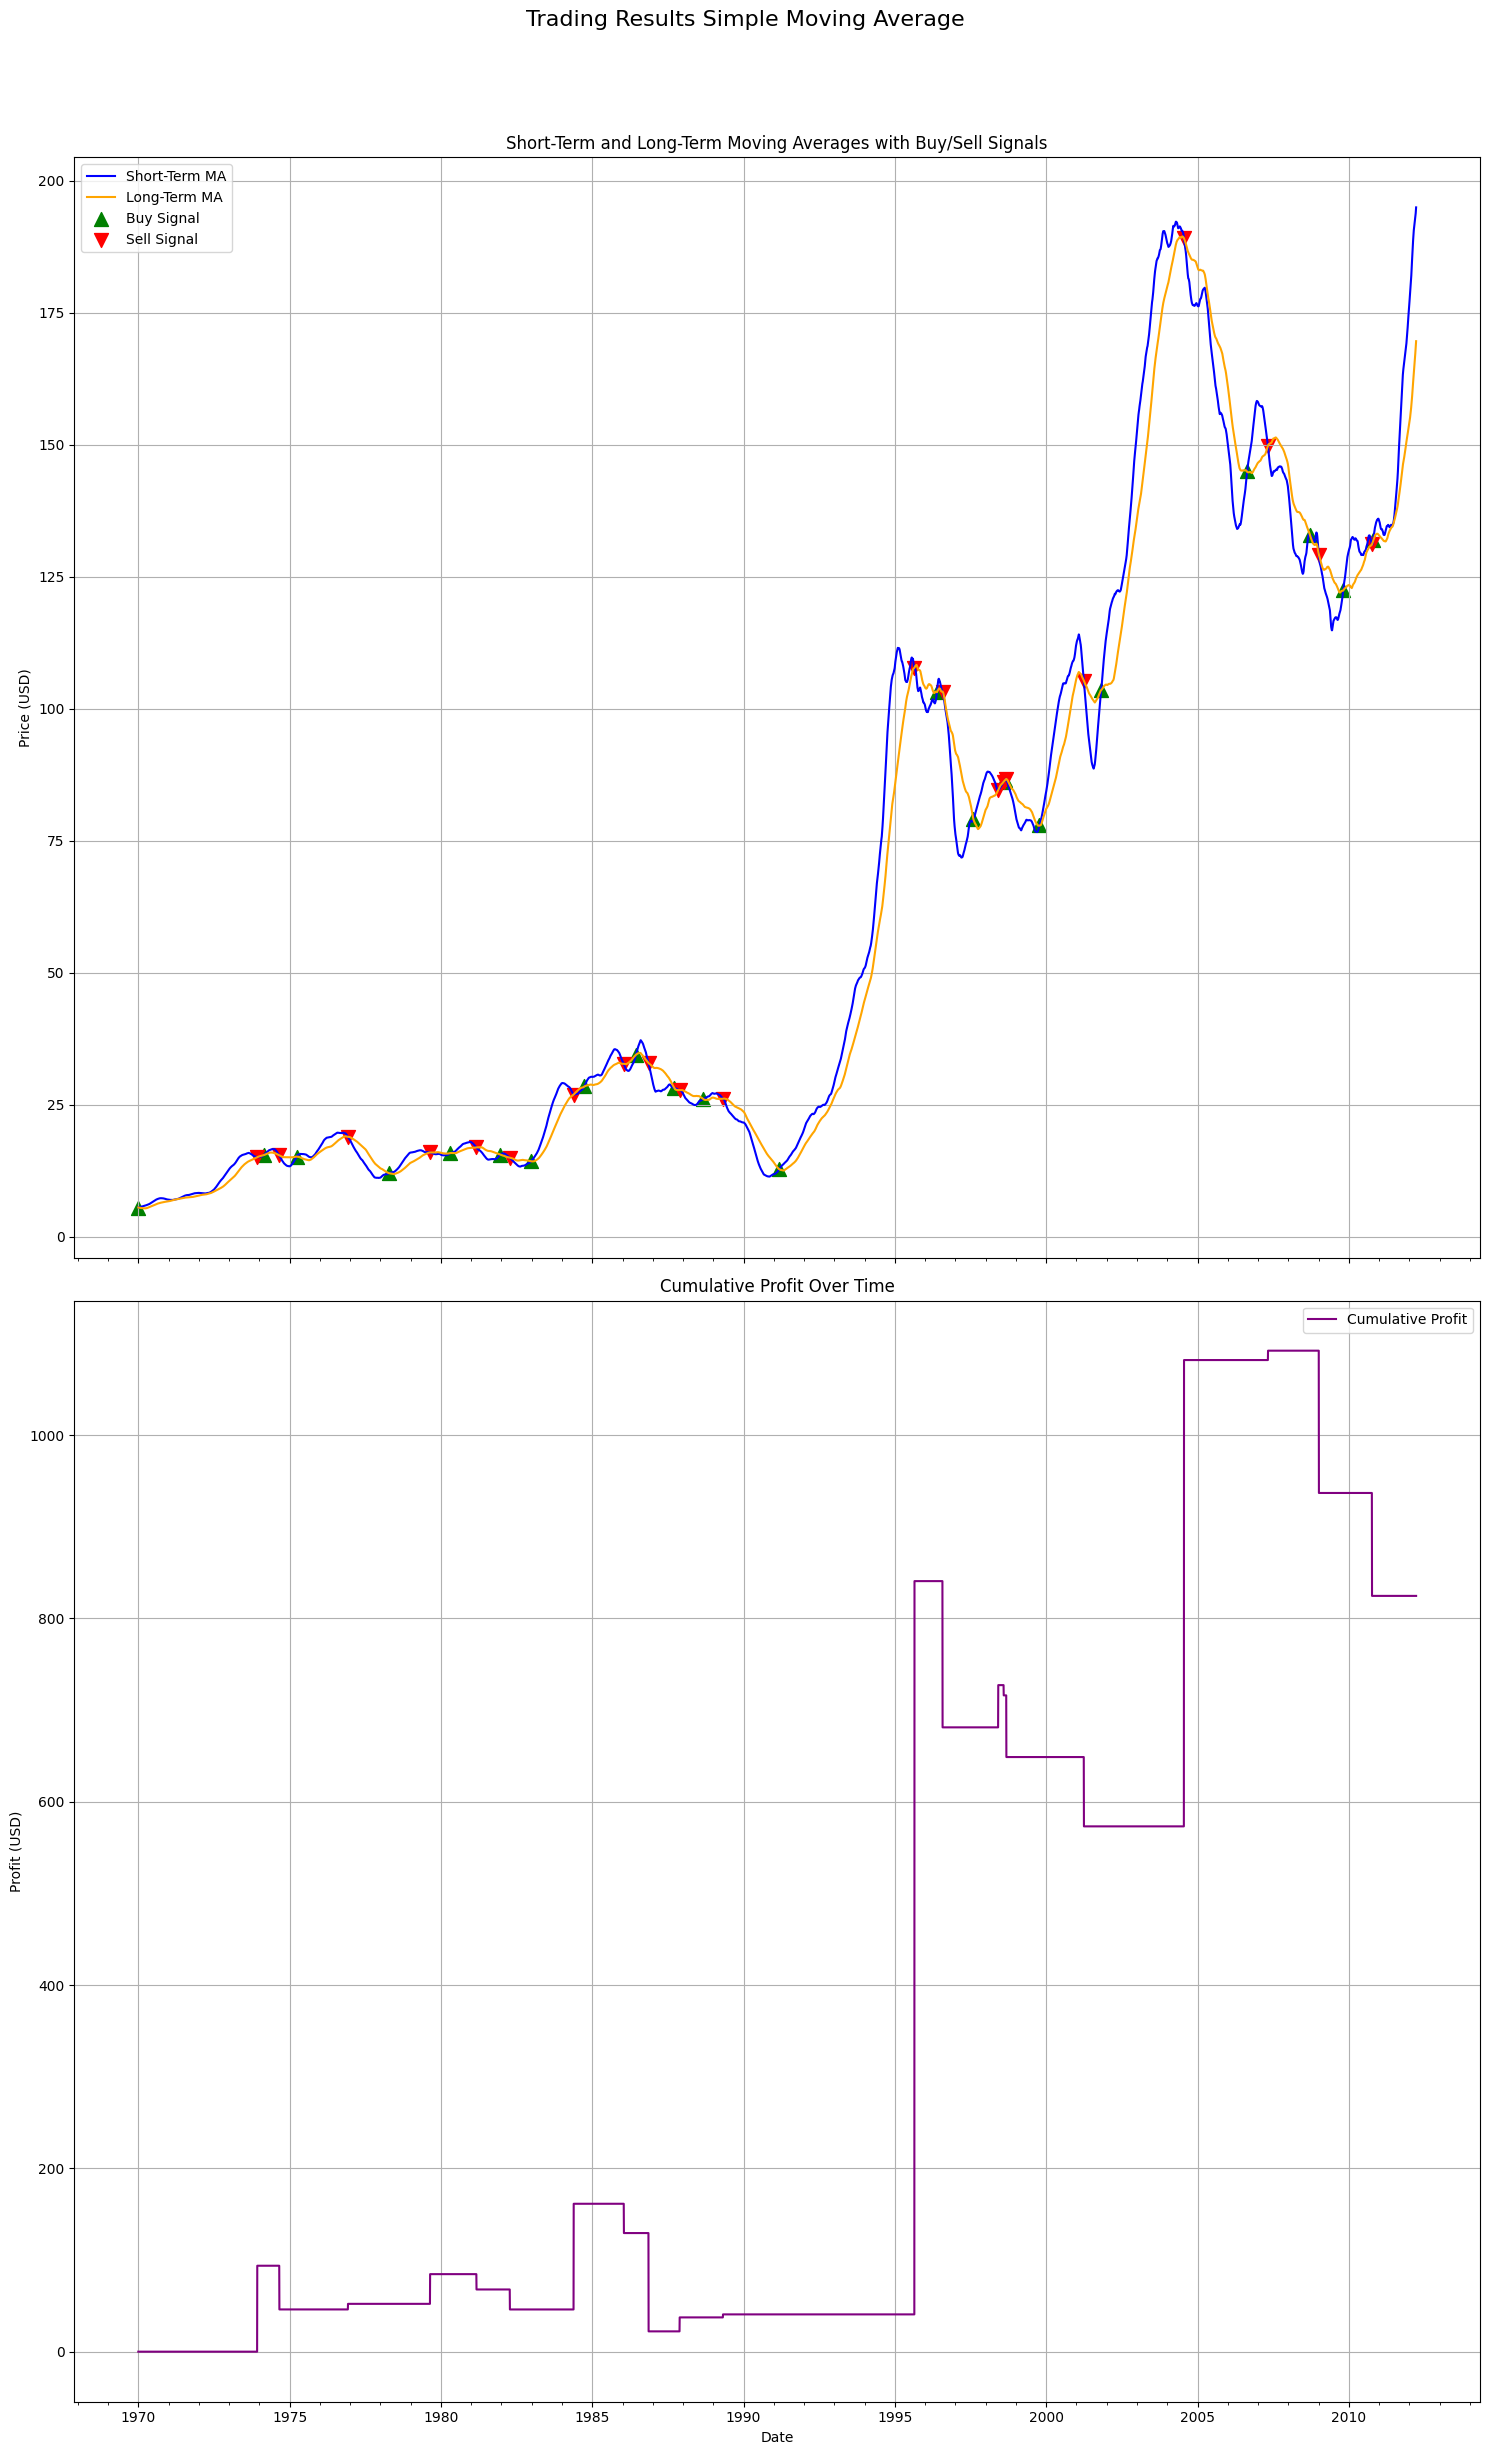

In [24]:
plot_trading_results(data_sma, title="Trading Results Simple Moving Average")

In [25]:
data_ema

,Close,Business_Cycle,short_window,long_window,signal,Action,Shares_Owned,Profit,Cumulative_Profit,Portfolio_Size
Date,,,,,,,,,,
1962-01-02,7.291268,Startup,7.291268,7.291268,0,Hold,0,0.000000,0.000000,0.000000
1962-01-03,7.355003,Startup,7.323224,7.323184,1,Buy,10,0.000000,0.000000,73.550029
1962-01-04,7.281708,Startup,7.309308,7.309316,-1,Sell,0,-0.732951,-0.732951,0.000000
1962-01-05,7.138305,Startup,7.266202,7.266369,0,Hold,0,0.000000,-0.732951,0.000000
1962-01-08,7.004461,Startup,7.213272,7.213670,0,Hold,0,0.000000,-0.732951,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-12-02,227.389999,Stable,181.013287,165.481706,0,Hold,10,0.000000,1003.120971,2273.899994
2024-12-03,229.000000,Stable,181.278407,165.673604,0,Hold,10,0.000000,1003.120971,2290.000000
2024-12-04,233.490005,Stable,181.566869,165.878488,0,Hold,10,0.000000,1003.120971,2334.900055


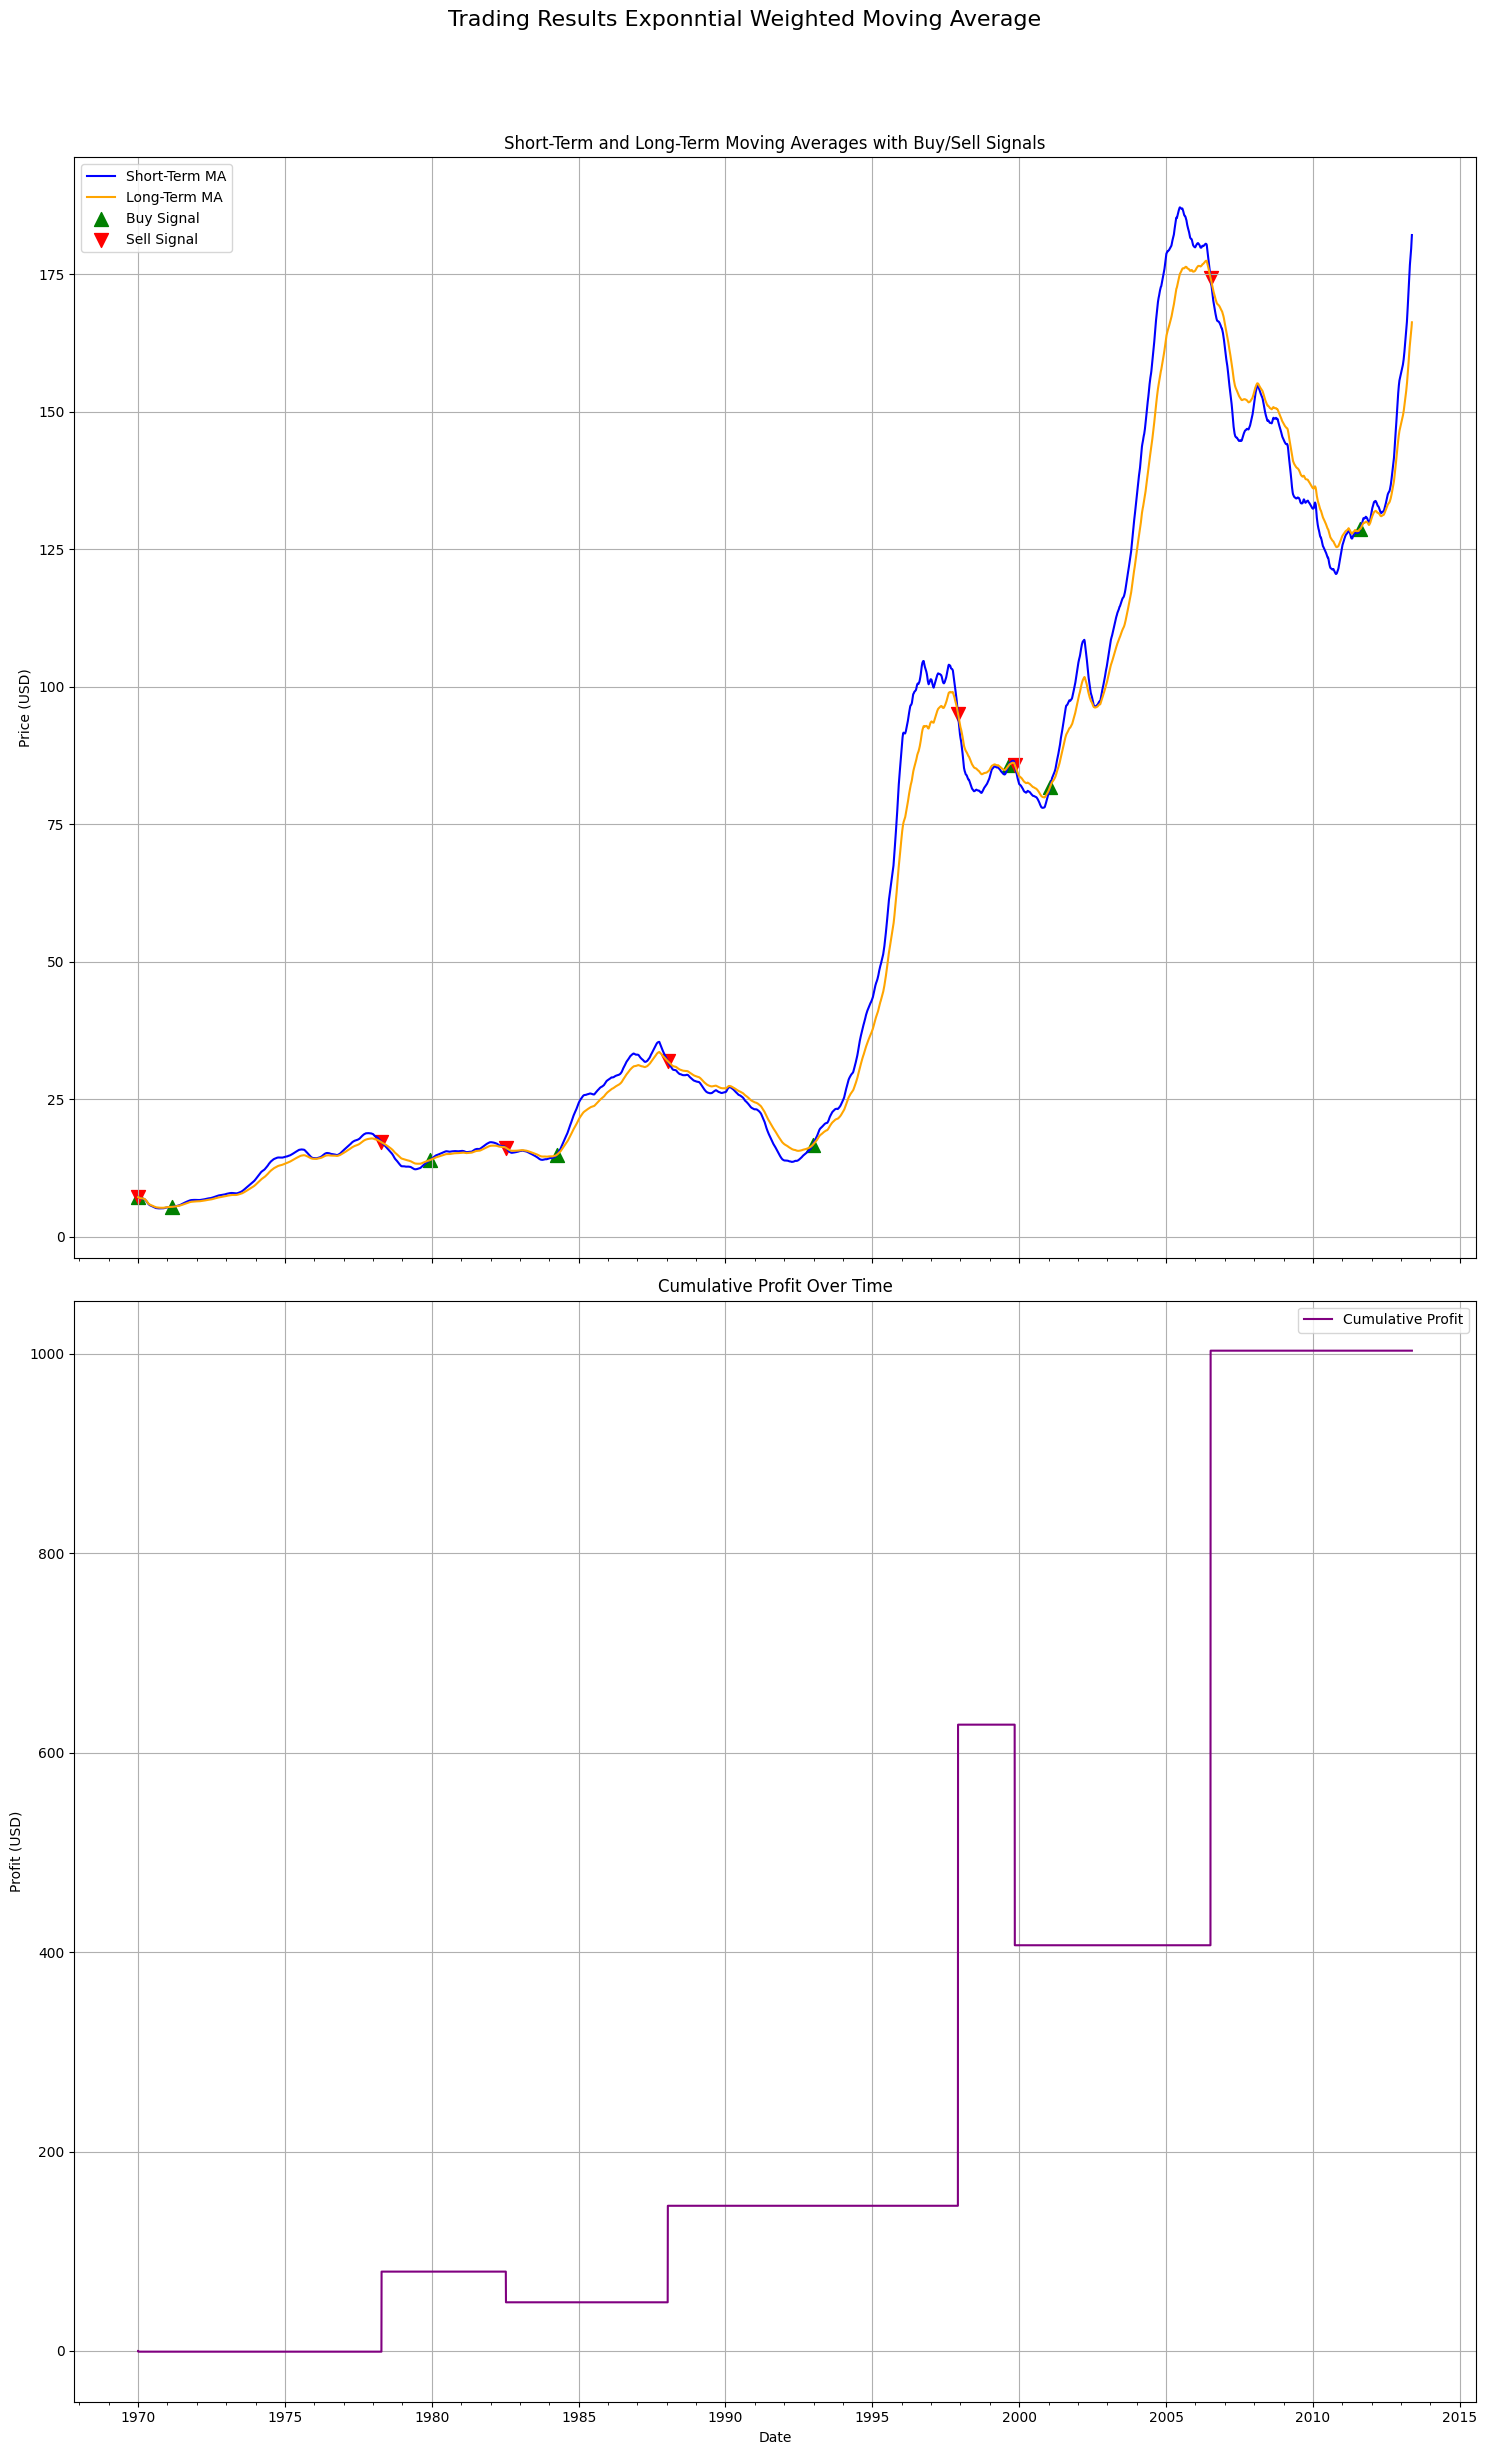

In [26]:
plot_trading_results(data_ema, title="Trading Results Exponntial Weighted Moving Average")

In [27]:
data_kalaman

,Date,Close,short_window,long_window,signal,Action,Shares_Owned,Profit,Cumulative_Profit,Portfolio_Size
0,1962-01-02,0.000000,0.000000,0.000000,0,Hold,0,0.0,0.000000,0.000000
1,1962-01-03,1.460697,0.732371,0.731564,1,Buy,10,0.0,0.000000,14.606966
2,1962-01-04,3.329263,1.602802,1.600346,0,Hold,10,0.0,0.000000,33.292629
3,1962-01-05,4.844574,2.419992,2.415456,0,Hold,10,0.0,0.000000,48.445738
4,1962-01-08,5.815468,3.106633,3.099992,0,Hold,10,0.0,0.000000,58.154683
...,...,...,...,...,...,...,...,...,...,...
15837,2024-12-02,219.149399,178.401974,165.748295,0,Hold,10,0.0,1203.979454,2191.493989
15838,2024-12-03,219.931354,178.631418,165.928305,0,Hold,10,0.0,1203.979454,2199.313535
15839,2024-12-04,221.007444,178.865539,166.111292,0,Hold,10,0.0,1203.979454,2210.074438
15840,2024-12-05,222.097904,179.104392,166.297295,0,Hold,10,0.0,1203.979454,2220.979045


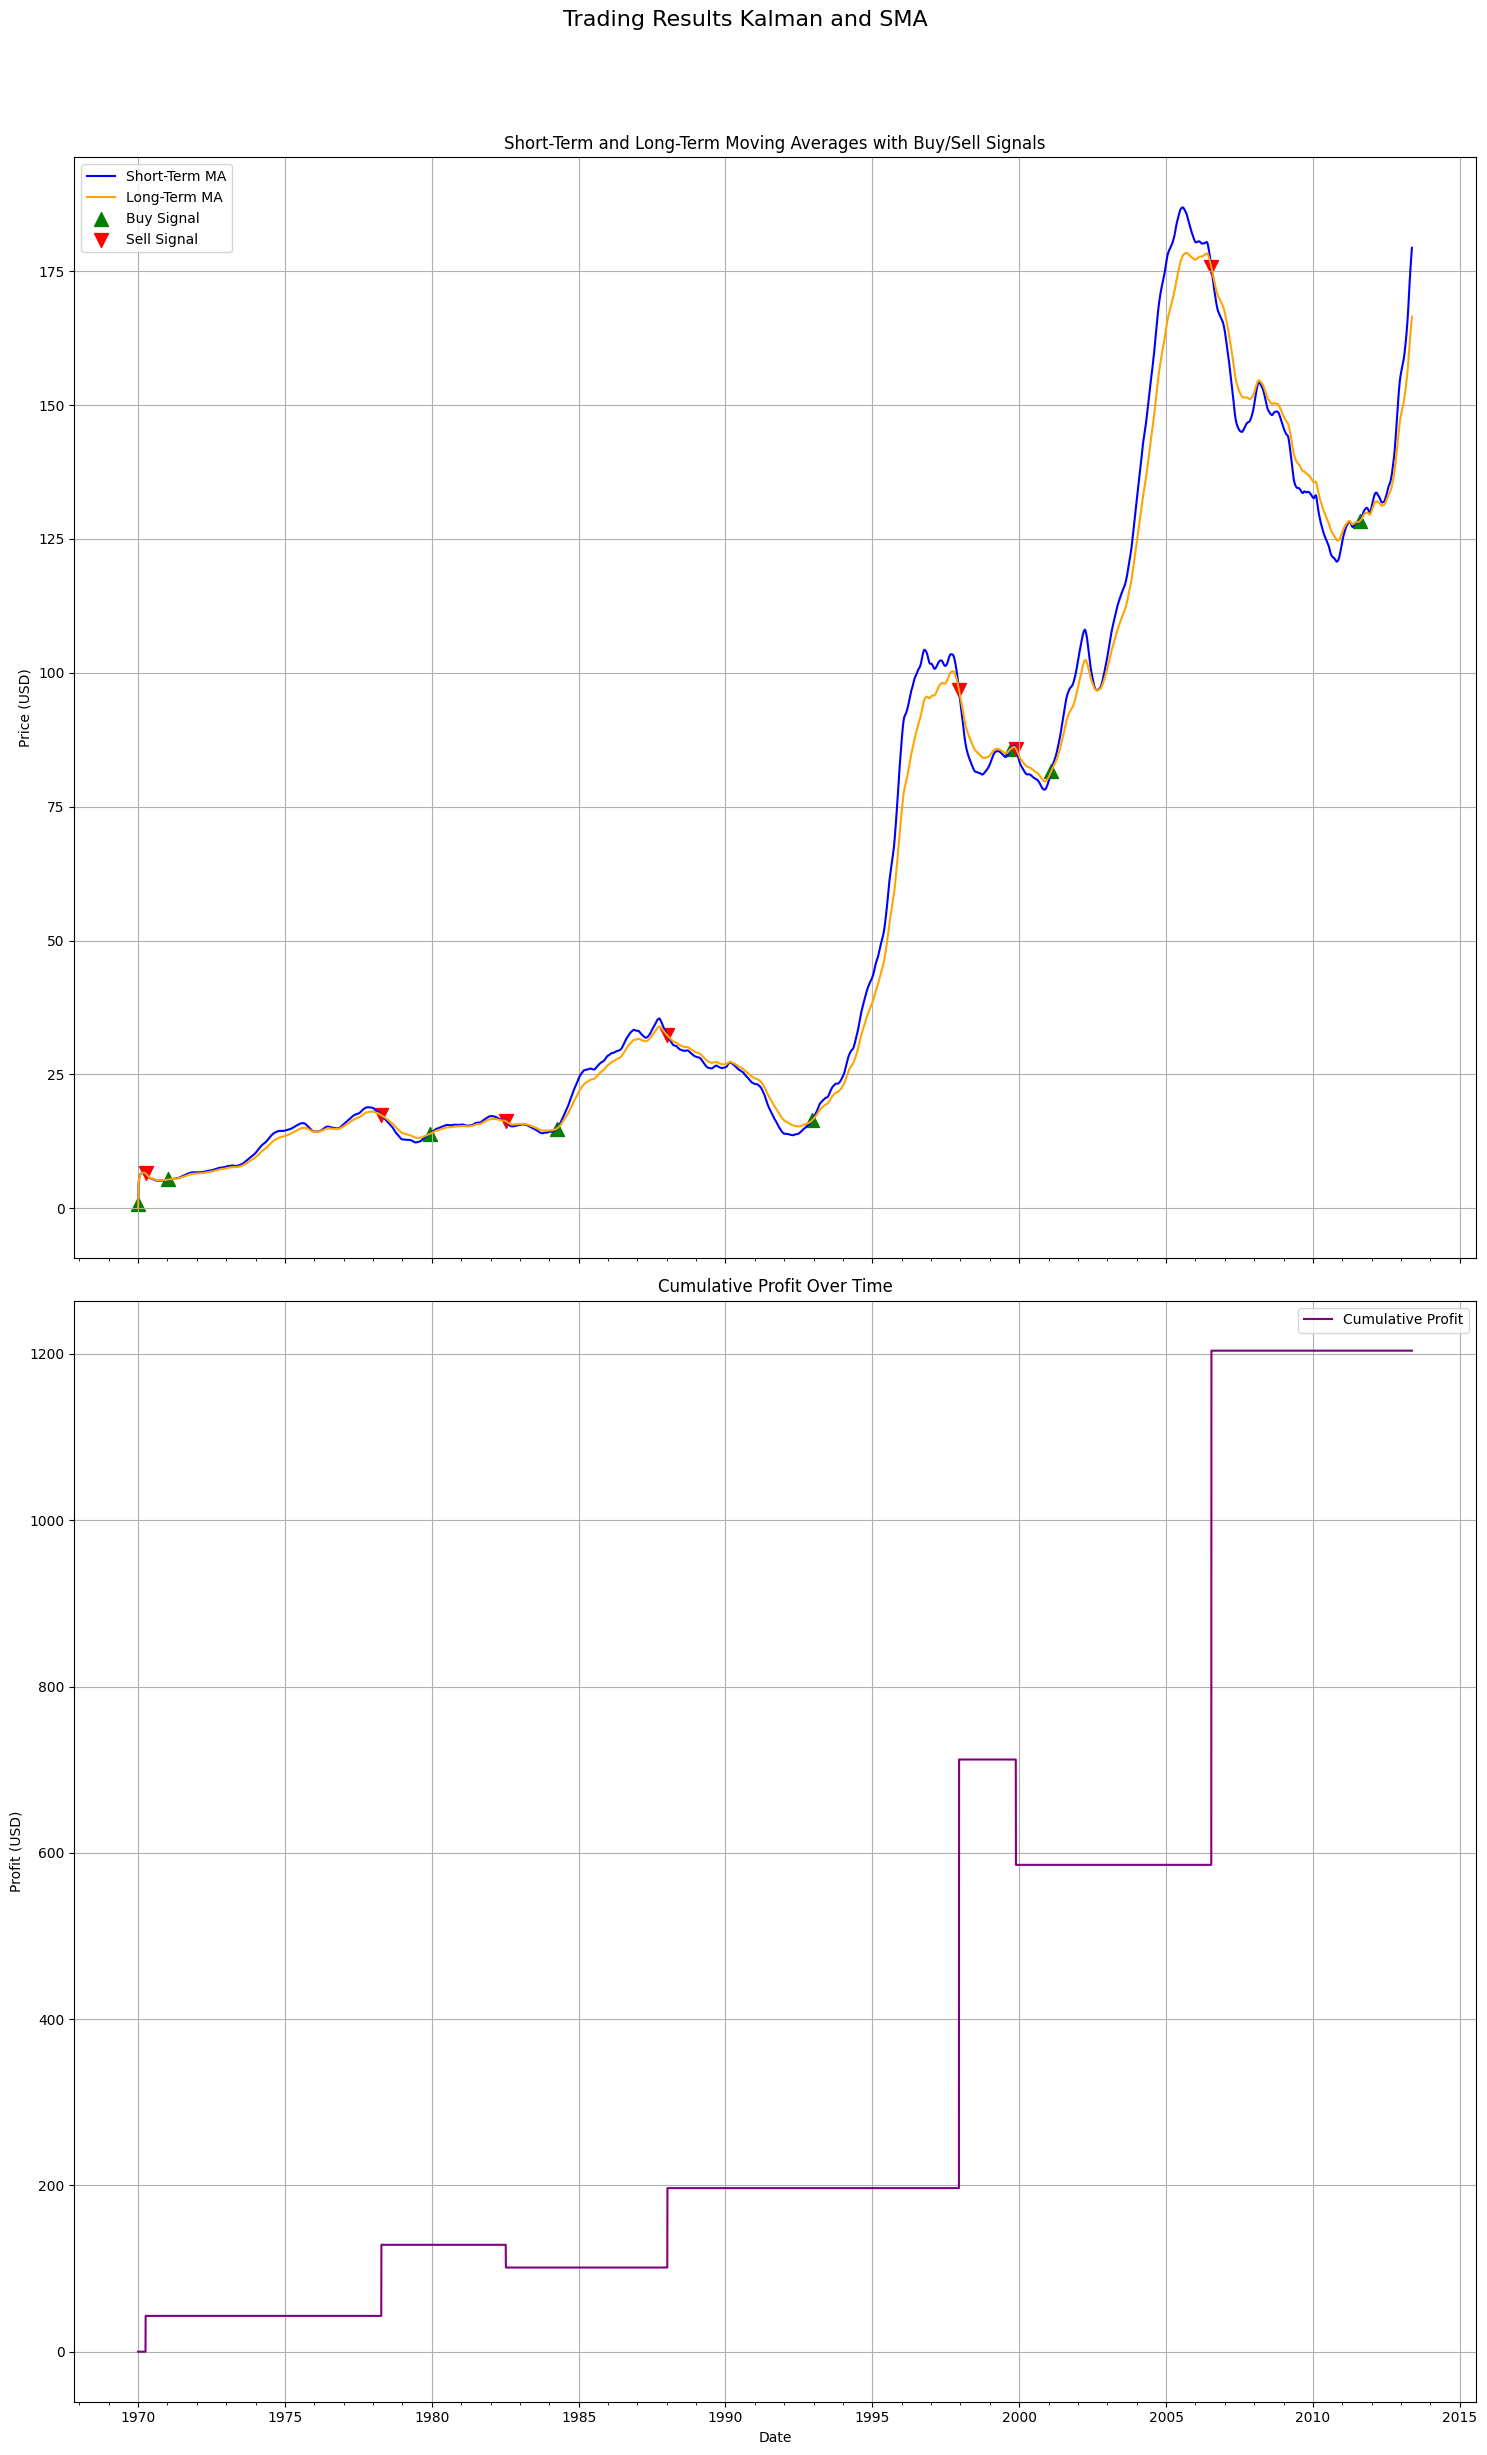

In [28]:
plot_trading_results(data_kalaman, title="Trading Results Kalman and SMA")